In [2]:
import json
import requests
import os
import zipfile
import geopandas as gpd
import pandas as pd
import contextily as cx
import numpy as np
import io
from pandas import json_normalize

# PREPARACIÓN DE LOS DATOS

## LEER DFrames del CENSO y Frecuencias Restaurantes generados en la etapa de exploración

In [ ]:
censo = pd.read_csv('censo_FIN.csv', index_col='Unnamed: 0')
censo

CVEMA  MUN         NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  \
0     0060000    6         Apodaca  0000       2993      7125    550134   
1     0060013    6         Apodaca  0013          0         0         0   
2     0060032    6         Apodaca  0032          0         0       175   
3     0060047    6         Apodaca  0047          0         0      1962   
4     0060051    6         Apodaca  0051         17        38      1290   
...       ...  ...             ...   ...        ...       ...       ...   
1640  0481647   48  Santa Catarina  1647          0         0       890   
1641  0481651   48  Santa Catarina  1651          4         0       560   
1642  0481666   48  Santa Catarina  1666          0         0        13   
1643  0481685   48  Santa Catarina  1685          0         0         0   
1644  0481702   48  Santa Catarina  1702          0         0         0   

      P6A11_NOAM   POBTOT  PSINDER  VIVPAR_HAB  VPH_EXCSA  VPH_LAVAD  \
0           2171  1303078   205545      347966     359894     330962   
1              0        0        0           0          0          0   
2              0      292       21          89         93         85   
3              0     3438      344        1042       1150       1039   
4             17     4488      559        1256       1300       1166   
...          ...      ...      ...         ...        ...        ...   
1640           0     2592      330         696        720        630   
1641           0     1070       74         218        236        236   
1642           0      134       13          28         28         21   
1643           0        0        0           0          0          0   
1644           0        0        0           0          0          0   

      VPH_NDEAED  VPH_PISOTI  VPH_REFRI  VPH_TELEF  
0             13        1276     354977     227230  
1              0           0          0          0  
2              0           0         91          0  
3              0           0       1142        632  
4              0           0       1278        774  
...          ...         ...        ...        ...  
1640           0           0        716          0  
1641           0           0        236        216  
1642           0           0         22          0  
1643           0           0          0          0  
1644           0           0          0          0  

[1645 rows x 17 columns]

In [ ]:
len(censo['CVEMA'].unique())

1645

In [ ]:
restaurantes = pd.read_csv('freq_rest.csv', index_col='Unnamed: 0')
restaurantes

CVEMA  \
0     0060051   
1     0060066   
2     0060070   
3     0060085   
4     006009A   
...       ...   
1288  0481562   
1289  0481581   
1290  0481609   
1291  0481628   
1292  0481702   

      Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida  \
0                                                     0                                                  
1                                                     1                                                  
2                                                     5                                                  
3                                                     7                                                  
4                                                     9                                                  
...                                                 ...                                                  
1288                                                  0                                                  
1289                                                  0                                                  
1290                                                  0                                                  
1291                                                  0                                                  
1292                                                  2                                                  

      Restaurante_Restaurantes con servicio de preparación de antojitos  \
0                                                     0                   
1                                                     5                   
2                                                     2                   
3                                                     2                   
4                                                     3                   
...                                                 ...                   
1288                                                  0                   
1289                                                  0                   
1290                                                  0                   
1291                                                  0                   
1292                                                  0                   

      Restaurante_Restaurantes con servicio de preparación de pescados y mariscos  \
0                                                     0                             
1                                                     1                             
2                                                     2                             
3                                                     2                             
4                                                     0                             
...                                                 ...                             
1288                                                  0                             
1289                                                  0                             
1290                                                  0                             
1291                                                  0                             
1292                                                  0                             

      Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar  \
0                                                     1                                                                        
1                                                     3                                                                        
2                                                     1                                                                        
3                                                     3                                         

In [ ]:
len(restaurantes['CVEMA'].unique())

1293

## LEER SHAPE AGEBS

Con el objetivo de agregar una columna que contenga información geografica de los agebs y que permita visualizarlos en un mapa se lee el archivo shapefile de los agebs del estado de Nuevo León

In [ ]:
#leemos el archicvo shape de los agebs de Nuevo León
shape = gpd.read_file("2023_1_19_A.shp").to_crs(4326)

#FILTRO PARA MUNICIPIOS AREA METROPOLITANA
municipios_clave = ['039','046','026','006','031','048','021','019']
shape = shape[shape['CVE_MUN'].isin(municipios_clave)]

#agrego una columna de identificación compuesta por el número de MUNICIPIO y AGEB
shape['CVEMA'] = shape['CVE_MUN'].map(str).str.zfill(3) + shape['CVE_AGEB'].map(str).str.zfill(4)

shape = shape.reset_index(drop = True)

In [ ]:
shape

CVEGEO CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  AMBITO  \
0     1900600011882      19     006    0001     1882  Urbana   
1     1900600011435      19     006    0001     1435  Urbana   
2     1900600011647      19     006    0001     1647  Urbana   
3     1900600011810      19     006    0001     1810  Urbana   
4     1900600010969      19     006    0001     0969  Urbana   
...             ...     ...     ...     ...      ...     ...   
1662  1904800011219      19     048    0001     1219  Urbana   
1663  1904800010954      19     048    0001     0954  Urbana   
1664  1904800011596      19     048    0001     1596  Urbana   
1665  1904800011632      19     048    0001     1632  Urbana   
1666  1903103131300      19     031    0313     1300  Urbana   

                                               geometry    CVEMA  
0     POLYGON ((-100.15091 25.71505, -100.15099 25.7...  0061882  
1     POLYGON ((-100.16946 25.75323, -100.16861 25.7...  0061435  
2     POLYGON ((-100.23345 25.77729, -100.23349 25.7...  0061647  
3     POLYGON ((-100.17821 25.79166, -100.17917 25.7...  0061810  
4     POLYGON ((-100.18562 25.77552, -100.18542 25.7...  0060969  
...                                                 ...      ...  
1662  POLYGON ((-100.45931 25.70913, -100.45931 25.7...  0481219  
1663  POLYGON ((-100.46389 25.71096, -100.46383 25.7...  0480954  
1664  POLYGON ((-100.50038 25.70305, -100.50044 25.7...  0481596  
1665  POLYGON ((-100.49398 25.71326, -100.49301 25.7...  0481632  
1666  POLYGON ((-100.15447 25.61207, -100.15316 25.6...  0311300  

[1667 rows x 8 columns]

In [ ]:
#para el merge nos interesa unicamente tener la clave Municipio-Ageb y su geometria
columns_mant = ['CVEMA','geometry']
agebs_coord = shape.loc[:,columns_mant]
agebs_coord

CVEMA                                           geometry
0     0061882  POLYGON ((-100.15091 25.71505, -100.15099 25.7...
1     0061435  POLYGON ((-100.16946 25.75323, -100.16861 25.7...
2     0061647  POLYGON ((-100.23345 25.77729, -100.23349 25.7...
3     0061810  POLYGON ((-100.17821 25.79166, -100.17917 25.7...
4     0060969  POLYGON ((-100.18562 25.77552, -100.18542 25.7...
...       ...                                                ...
1662  0481219  POLYGON ((-100.45931 25.70913, -100.45931 25.7...
1663  0480954  POLYGON ((-100.46389 25.71096, -100.46383 25.7...
1664  0481596  POLYGON ((-100.50038 25.70305, -100.50044 25.7...
1665  0481632  POLYGON ((-100.49398 25.71326, -100.49301 25.7...
1666  0311300  POLYGON ((-100.15447 25.61207, -100.15316 25.6...

[1667 rows x 2 columns]

## MERGE ENTRE BASES DE DATOS

In [ ]:
#se hace un merge entre el df del censo y el de las geometrías
censo_coord = gpd.GeoDataFrame(pd.merge(agebs_coord, censo, on='CVEMA'))
censo_coord.head()

CVEMA                                           geometry  MUN  NOM_MUN  \
0  0061882  POLYGON ((-100.15091 25.71505, -100.15099 25.7...    6  Apodaca   
1  0061435  POLYGON ((-100.16946 25.75323, -100.16861 25.7...    6  Apodaca   
2  0061647  POLYGON ((-100.23345 25.77729, -100.23349 25.7...    6  Apodaca   
3  0061810  POLYGON ((-100.17821 25.79166, -100.17917 25.7...    6  Apodaca   
4  0060969  POLYGON ((-100.18562 25.77552, -100.18542 25.7...    6  Apodaca   

   AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  POBTOT  PSINDER  \
0  1882         10        67      3404           0   10712     2186   
1  1435          5        16      4582           4    9224     1185   
2  1647          3         6      2822           0    4650      638   
3  1810         35         0      1884          24    3382      419   
4  0969          0         0         0           0       0        0   

   VIVPAR_HAB  VPH_EXCSA  VPH_LAVAD  VPH_NDEAED  VPH_PISOTI  VPH_REFRI  \
0        2716       2828       2596           0           3       2786   
1        2518       2562       2392           0           0       2538   
2        1382       1412       1354           0           0       1404   
3         994       1040        990           0          10       1038   
4           0          0          0           0           0          0   

   VPH_TELEF  
0       1874  
1       1712  
2       1128  
3        738  
4          0

A partir de esto es posible graficar en un mapa los AGEBS y pueden ser clasificados a partir de las columnas del censo. Por ejemplo acontinuación se muestra la separación de los AGEBs por municipio:

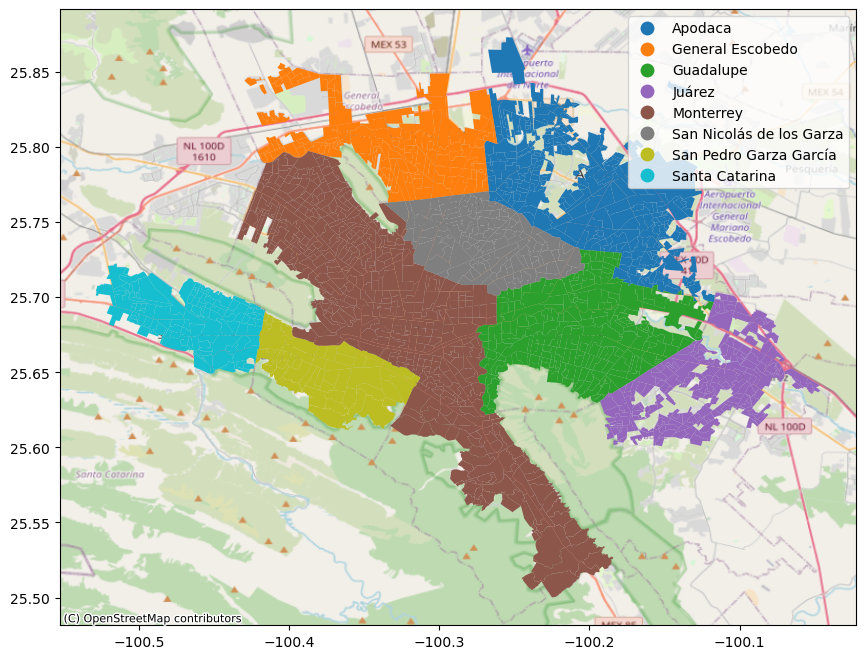

In [ ]:
ax = censo_coord.plot("NOM_MUN", cmap="tab10", legend=True, figsize=(14, 8))
cx.add_basemap(ax, crs=censo_coord.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
#se hace un merge entre el df de la frecuencia de restaurantes y el df que acaba de ser generado en el paso anterior
df = gpd.GeoDataFrame(pd.merge(censo_coord , restaurantes, on='CVEMA'))
df.head()

CVEMA                                           geometry  MUN  NOM_MUN  \
0  0061882  POLYGON ((-100.15091 25.71505, -100.15099 25.7...    6  Apodaca   
1  0061435  POLYGON ((-100.16946 25.75323, -100.16861 25.7...    6  Apodaca   
2  0061647  POLYGON ((-100.23345 25.77729, -100.23349 25.7...    6  Apodaca   
3  0060969  POLYGON ((-100.18562 25.77552, -100.18542 25.7...    6  Apodaca   
4  006030A  POLYGON ((-100.16562 25.73954, -100.16554 25.7...    6  Apodaca   

   AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  POBTOT  ...  VPH_PISOTI  \
0  1882         10        67      3404           0   10712  ...           3   
1  1435          5        16      4582           4    9224  ...           0   
2  1647          3         6      2822           0    4650  ...           0   
3  0969          0         0         0           0       0  ...           0   
4  030A         10        15      2860           7    8268  ...           3   

   VPH_REFRI  VPH_TELEF  \
0       2786       1874   
1       2538       1712   
2       1404       1128   
3          0          0   
4       2168       1343   

   Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida  \
0                                                  0                                                  
1                                                  0                                                  
2                                                  0                                                  
3                                                  8                                                  
4                                                  0                                                  

   Restaurante_Restaurantes con servicio de preparación de antojitos  \
0                                                  2                   
1                                                  0                   
2                                                  0                   
3                                                  2                   
4                                                  1                   

   Restaurante_Restaurantes con servicio de preparación de pescados y mariscos  \
0                                                  0                             
1                                                  0                             
2                                                  0                             
3                                                  1                             
4                                                  0                             

   Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar  \
0                                                  3                                                                        
1                                                  1                                                                        
2                                                  2                                                                        
3                                                  3                                                                        
4                                                  1                                                                        

   Restaurante_Restaurantes con servicio de preparación de tacos y tortas  \
0                                                  3                        
1                                                  1                        
2                                                  1                        
3                                                  3                        
4                                                  0                        

   Restaurante_Restaurantes de autoservicio  \
0                                         1   
1                                      

**Decisión sobre el conjunto de datos**

Los datos finales de el dataframe incluyen información demográfica y de frecuencia de restaurantes para diferentes AGEBS en Monterrey.

Estos datos son relevantes para el análisis demográfico y de restaurantes en Monterrey, ya que proporcionan información sobre la población en diferentes áreas, así como sobre la disponibilidad y la frecuencia de diferentes tipos de restaurantes.

Datos excluidos: En este caso se exluyeron más de cien columnas y registros que fueron descartadas en la etapa de exploración.

In [ ]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 25 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype   
---  ------                                                                                                                  --------------  -----   
 0   CVEMA                                                                                                                   1287 non-null   object  
 1   geometry                                                                                                                1287 non-null   geometry
 2   MUN                                                                                                                     1287 non-null   int64   
 3   NOM_MUN                                                                                                                 1287 non-n

In [ ]:
#exportamos base de datos final

df.to_file('DF_FINAL.shp')

C:\Users\alexa\AppData\Local\Temp\ipykernel_38844\209899698.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('DF_FINAL.shp')


# CLUSTERING POR RESTAURANTES

El objetivo principal de este proyecto es lograr dar recomendaciones de posibles ubicaciones para abrir restaurantes de cierto giro.
El primer para conseguir esto es usar K-means para agrupar los AGEBs en clusters, utilizando datos de frecuencia de restaurantes. Estos clusters serviránpara identificar patrones y similitudes entre diferentes áreas en términos de la disponibilidad y variedad de restaurantes.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [ ]:
# columnas relevantes para el clustering
columnas_clustering = [
    'Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
    'Restaurante_Restaurantes con servicio de preparación de antojitos',
    'Restaurante_Restaurantes con servicio de preparación de pescados y mariscos',
    'Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar',
    'Restaurante_Restaurantes con servicio de preparación de tacos y tortas',
    'Restaurante_Restaurantes de autoservicio',
    'Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar'
]

# creo dataframe solo con las colmnas seleccionadas
datos_clustering = df[columnas_clustering]


Debido a que las variables de frecuencia de restaurantes pueden tener diferentes escalas y magnitudes, la normalización garantiza que todas las variables contribuyan equitativamente al cálculo de la distancia entre puntos. Es por esto ue se normalizan los datos para entrenar el modelo:

In [ ]:
# Normalizamos los datos
scaler = StandardScaler()
datos_normalizados = scaler.fit_transform(datos_clustering)


In [ ]:
# número de clusters
num_clusters = 3

# se crea el modelo de k-means y se entrena el modelo
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(datos_normalizados)


c:\Users\alexa\anaconda3\envs\tecmx\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=0)

In [ ]:
# se agregan las etiquetas del clustering al df original
df['Cluster'] = kmeans.labels_

# distribución de los clusters
print(df['Cluster'].value_counts())


Cluster
2    826
1    401
0     60
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt


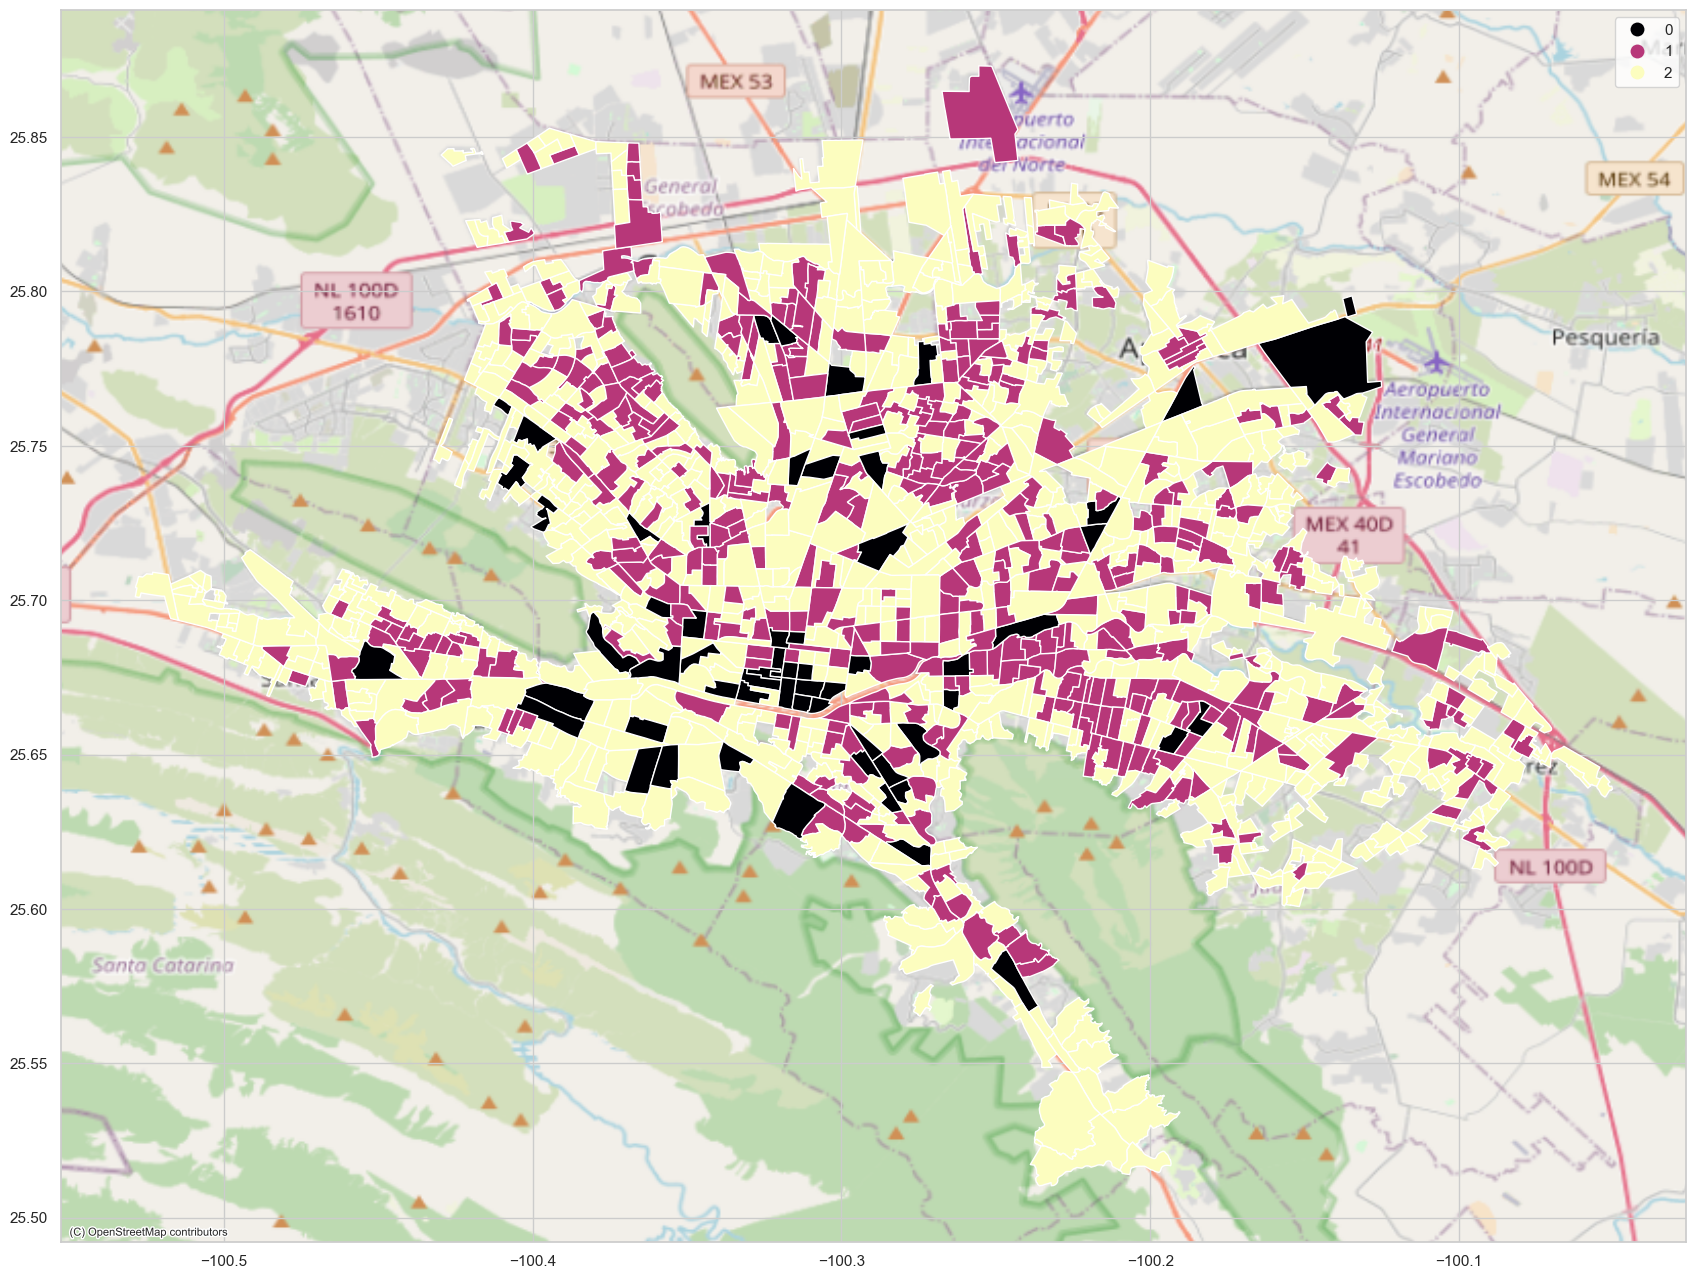

In [ ]:
#mostrar clusters en el mapa
ax = df.plot("Cluster", cmap="magma", legend=True, figsize=(28, 16), categorical =True)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Ya se ha etiquetado cada AGEB, pero **¿qué nos dice esta etiqueta?** Con el fin de comprender mejor las características de cada grupo, se calcularán estadísticos descriptivos esperando identificar patrones dentro de cada cluster.

In [ ]:
# se seleccionan las columnas numéricas relevantes para el clustering
columnas_numericas = df.select_dtypes(include=np.number).columns.tolist()
columnas_numericas.remove('Cluster')

# se calcula el promedio de cada variable numérica para cada cluster
medias_por_cluster = df.groupby('Cluster')[columnas_numericas].mean()

# solo las columnas de restaurantes
columnas_restaurantes = [
    'Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
    'Restaurante_Restaurantes con servicio de preparación de antojitos',
    'Restaurante_Restaurantes con servicio de preparación de pescados y mariscos',
    'Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar',
    'Restaurante_Restaurantes con servicio de preparación de tacos y tortas',
    'Restaurante_Restaurantes de autoservicio',
    'Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar'
]
medias_restaurantes_por_cluster = medias_por_cluster[columnas_restaurantes]

# Muestra las medias de frecuencia de restaurantes por cluster
medias_restaurantes_por_cluster

Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida  \
Cluster                                                                                                     
0                                                14.266667                                                  
1                                                 1.623441                                                  
2                                                 0.840194                                                  

         Restaurante_Restaurantes con servicio de preparación de antojitos  \
Cluster                                                                      
0                                                 3.983333                   
1                                                 2.740648                   
2                                                 0.700969                   

         Restaurante_Restaurantes con servicio de preparación de pescados y mariscos  \
Cluster                                                                                
0                                                 2.266667                             
1                                                 0.675810                             
2                                                 0.192494                             

         Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar  \
Cluster                                                                                                                           
0                                                 3.633333                                                                        
1                                                 3.683292                                                                        
2                                                 1.039952                                                                        

         Restaurante_Restaurantes con servicio de preparación de tacos y tortas  \
Cluster                                                                           
0                                                 9.633333                        
1                                                 6.588529                        
2                                                 2.116223                        

         Restaurante_Restaurantes de autoservicio  \
Cluster                                             
0                                        4.733333   
1                                        0.531172   
2                                        0.242131   

         Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar  
Cluster                                                                            
0                                                 2.450000                         
1                                                 0.765586                         
2                                                 0.343826

In [ ]:
medias_restaurantes_por_cluster.reset_index(inplace=True)
medias_restaurantes_melted = pd.melt(medias_restaurantes_por_cluster, id_vars=['Cluster'], var_name='Tipo de Restaurante', value_name='Frecuencia Promedio')

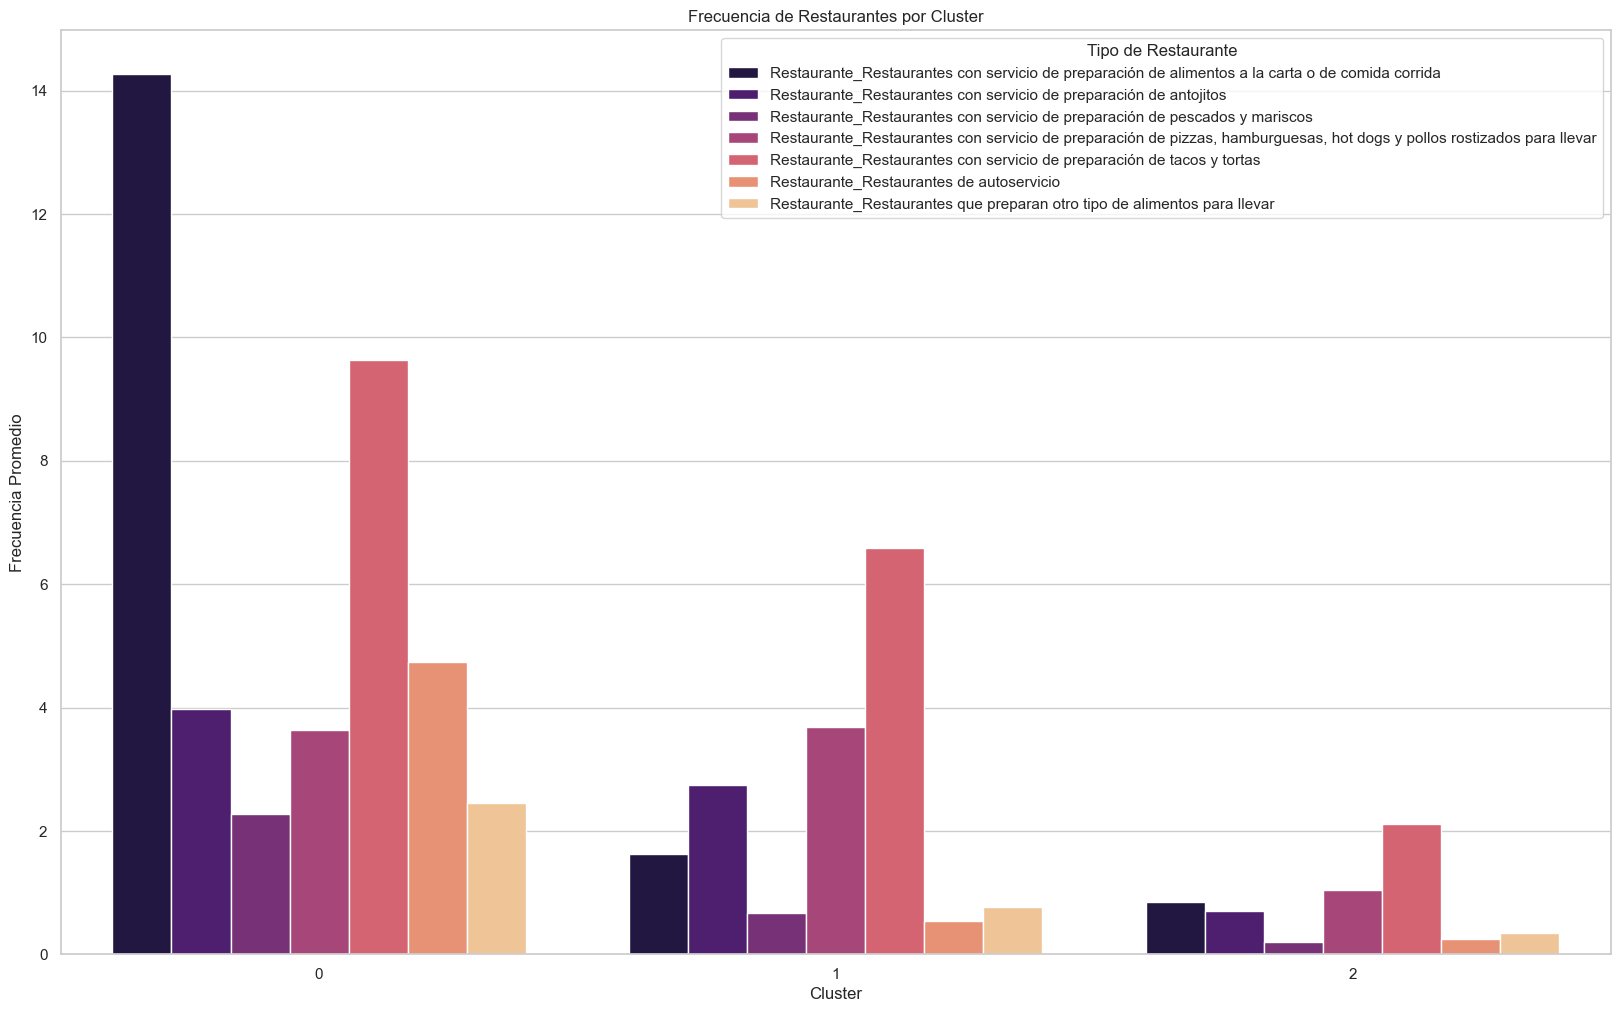

In [ ]:
# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Gráfico de barras para las medias de frecuencia de restaurantes por cluster
plt.figure(figsize=(20, 12))
sns.barplot(data=medias_restaurantes_melted,
            x='Cluster', y='Frecuencia Promedio', hue='Tipo de Restaurante', palette='magma')
plt.title('Frecuencia de Restaurantes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia Promedio')
plt.legend(title='Tipo de Restaurante')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x
plt.show()

**Cluster 0:** Tiene una frecuencia relativamente alta en todos los tipos de restaurantes, especialmente en los de alimentos a la carta o de comida corrida, tacos y tortas, y de autoservicio. Esto sugiere una zona con una variedad amplia de opciones de comida, que podría ser un área comercial o residencial densamente poblada.

**Cluster 1:** Tiene frecuencias moderadas en la mayoría de los tipos de restaurantes, con las más altas en restaurantes de pizzas, hamburguesas, hot dogs y pollos rostizados, y tacos y tortas. Esto podría indicar un área más equilibrada en términos de opciones de comida, posiblemente una combinación de áreas residenciales y comerciales.

**Cluster 2:** Tiene las frecuencias más bajas en general, con las más altas en restaurantes de alimentos a la carta o de comida corrida y tacos y tortas. Esto sugiere un área con menos opciones de comida y posiblemente menos densamente poblada, como áreas suburbanas o rurales.

## CLUSTERING POR DEMOGRAFÍA

In [ ]:
columnas_DEMOG = [
    'P12A14NOA', 'P15YM_AN', 'P18YM_PB', 'P6A11_NOAM', 'POBTOT', 'PSINDER',
    'VIVPAR_HAB', 'VPH_EXCSA', 'VPH_LAVAD', 'VPH_NDEAED', 'VPH_PISOTI',
    'VPH_REFRI', 'VPH_TELEF'
]

# Selecciona solo las columnas relevantes para el clustering
datos_clustering_dem = df[columnas_DEMOG]

# Normaliza los datos
scaler = StandardScaler()
datos_normalizados_dem = scaler.fit_transform(datos_clustering_dem )

# Define el número de clusters
num_clusters = 3

# Aplica el algoritmo de clustering (k-means)
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(datos_normalizados_dem)

# Agrega los resultados del clustering al DataFrame original
df['Cluster_dem'] = kmeans.labels_

# Muestra la distribución de los clusters
print(df['Cluster_dem'].value_counts())

c:\Users\alexa\anaconda3\envs\tecmx\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster_dem
2    612
1    464
0    211
Name: count, dtype: int64


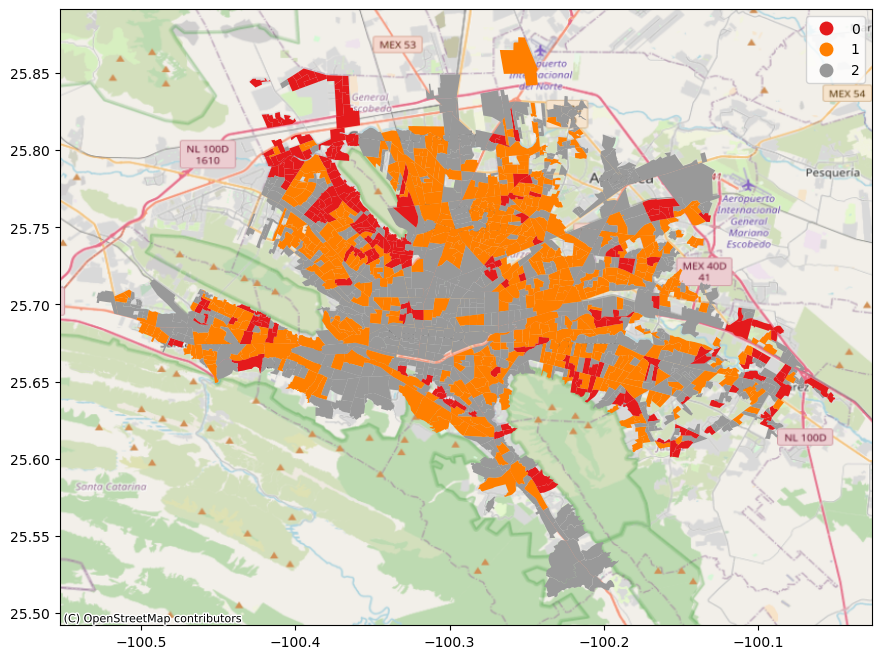

In [ ]:
ax = df.plot("Cluster_dem", cmap="Set1", legend=True, figsize=(14, 8), categorical =True)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

## CLUSTERING GENERAL

In [ ]:
columnas_GEN =  [
    'P12A14NOA', 'P15YM_AN', 'P18YM_PB', 'P6A11_NOAM', 'POBTOT', 'PSINDER',
    'VIVPAR_HAB', 'VPH_EXCSA', 'VPH_LAVAD', 'VPH_NDEAED', 'VPH_PISOTI',
    'VPH_REFRI', 'VPH_TELEF',
    'Restaurante_Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
    'Restaurante_Restaurantes con servicio de preparación de antojitos',
    'Restaurante_Restaurantes con servicio de preparación de pescados y mariscos',
    'Restaurante_Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar',
    'Restaurante_Restaurantes con servicio de preparación de tacos y tortas',
    'Restaurante_Restaurantes de autoservicio',
    'Restaurante_Restaurantes que preparan otro tipo de alimentos para llevar'
]


# Selecciona solo las columnas relevantes para el clustering
datos_clustering_gen = df[columnas_GEN]

# Normaliza los datos
scaler = StandardScaler()
datos_normalizados_gen = scaler.fit_transform(datos_clustering_gen)

# Define el número de clusters
num_clusters = 3

# Aplica el algoritmo de clustering (k-means)
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(datos_normalizados_gen)

# Agrega los resultados del clustering al DataFrame original
df['Cluster_gen'] = kmeans.labels_

# Muestra la distribución de los clusters
print(df['Cluster_gen'].value_counts())

c:\Users\alexa\anaconda3\envs\tecmx\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster_gen
2    645
0    367
1    275
Name: count, dtype: int64


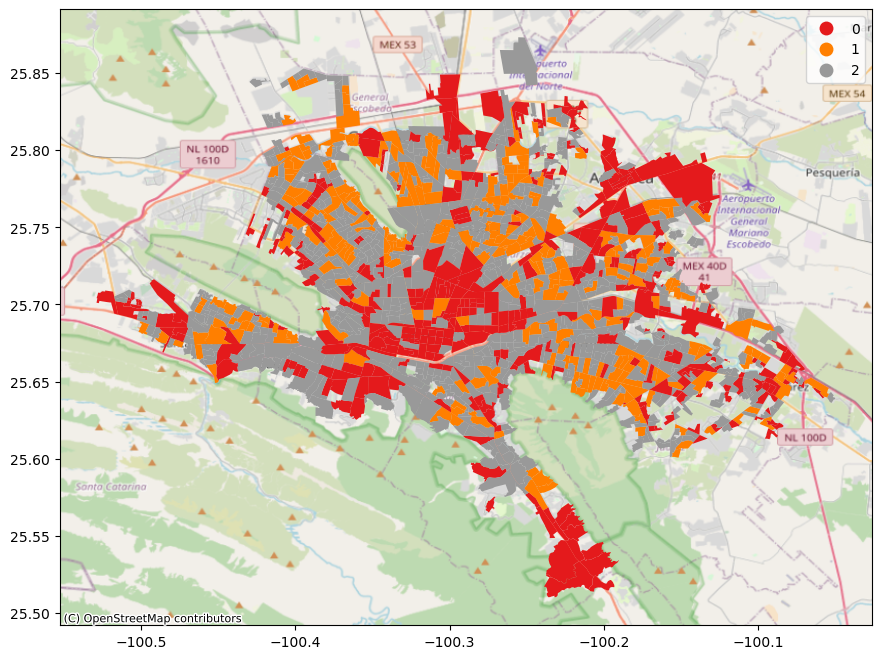

In [ ]:
ax = df.plot("Cluster_gen", cmap="Set1", legend=True, figsize=(14, 8), categorical =True)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)